In [43]:
from IPython.display import Image, display
from IPython.display import HTML
from IPython.display import display, Markdown

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas as pd
import prettytable

In [45]:
## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Cost-effective deep active learning**

In this experiment, we try to see if and how cost-effective classification reduces the calibration error of machine learning models. We compare the performance of diversity sampling, uncertainty sampling and random sampling. We use the scikit-learn's MLP model with the optimal parameters we found via hyperparameter search.

We defined three parameters to control the cost of errors: 



1.   Cost of obtaining a false positive (FPC)
2.   Cost of obtaining a false negative (FPN)
3.   Cost of asking the label of an instance to humans (CH)






In [46]:
x = PrettyTable()
column_names = ["Dataset", "Train/val/test", "Classes", "Number of active learning batches", "Batch Size", "Size of initial training data"]
x.add_column(column_names[0], ['Gop Sentiment', 'Disaster Relevance', 'Economic news article tone and relevance','Chems Contributing to Disease','Corporate messaging', 'Sentiment Self-driving Cars', 'Drug relation'])
x.add_column(column_names[1], ["6195/576/628", "7557/740/684", "5098/452/526","3088/186/162","2615/120/117", "5399/150/147", "1866/75/72"])
x.add_column(column_names[2], [2, 2, 2, 2, 3, 3, 3])
x.add_column(column_names[3], ["10","10","10","10","10","10","10"])
x.add_column(column_names[4], ["600", "740", "500", "300", "255", "530", "180"])
x.add_column(column_names[5], ["195", "157", "98", "88", "66", "99", "66"])
print(x)

+------------------------------------------+----------------+---------+-----------------------------------+------------+-------------------------------+
|                 Dataset                  | Train/val/test | Classes | Number of active learning batches | Batch Size | Size of initial training data |
+------------------------------------------+----------------+---------+-----------------------------------+------------+-------------------------------+
|              Gop Sentiment               |  6195/576/628  |    2    |                 10                |    600     |              195              |
|            Disaster Relevance            |  7557/740/684  |    2    |                 10                |    740     |              157              |
| Economic news article tone and relevance |  5098/452/526  |    2    |                 10                |    500     |               98              |
|      Chems Contributing to Disease       |  3088/186/162  |    2    |           

In [47]:
def printSelectedItems(eval_outliers, data):
    print("Sampled items in the first batch:")
    sampled_items = []
    outliers = str(eval_outliers).split()
    for outlier in outliers:
        outlier_id = int(outlier)
        outlier_text = data.loc[data['itemID'] == outlier_id].text.values
        if len(outlier_text) != 0 and outlier_text[0] not in sampled_items:
            sampled_items.append(outlier_text[0])

    for item in sampled_items:
        print("\n", item)

def printPrettyTable(title, column_names, datasetName, eval, test):
    x = PrettyTable()
    x.title = title
    x.add_column(column_names[0], [datasetName, '', '', '', '', '', '', '', '', ''])
    x.add_column(column_names[1], test['alBatch'] )
    x.add_column(column_names[2], eval[' f1_val'])
    x.add_column(column_names[3], eval[' ece_val'])
    x.add_column(column_names[4], test[' f1_val'])
    x.add_column(column_names[5], test[' ece_val'])
    print(x)

def plot_performance(dataList, titleList, figTitle):
    fig, ax = plt.subplots(nrows = 3, ncols=4, figsize=(35, 25))
    plt.figtext(.5,.9,figTitle, fontsize=40, ha='center')
    for j in range(len(dataList)):
        for i in range(3):
            data = dataList[j]
            title = titleList[j]
            y_f1 = []
            y_ece = []
            y_brier = []
            y_cost = []
            for el in data[i][1]:
                y_f1.append(el[0])
                y_ece.append(el[1])
                y_brier.append(el[2])
                y_cost.append(el[3])

            for y_arr, label in zip(y_f1, data[i][4]):
                ax[i][0].plot(data[i][0], y_arr, label=label + ' ' + title)

            for y_arr, label in zip(y_ece, data[i][4]):
                ax[i][1].plot(data[i][0], y_arr, label=label + ' ' + title)

            for y_arr, label in zip(y_brier, data[i][4]):
                ax[i][2].plot(data[i][0], y_arr, label=label + ' ' + title)

            for y_arr, label in zip(y_cost, data[i][4]):
                ax[i][3].plot(data[i][0], y_arr, label=label + ' ' + title)
    
            ax[i][0].set_title('F1 Scores on ' + data[i][5] + ' set')
            ax[i][0].set_xlabel(data[i][2])
            ax[i][0].set_ylabel(data[i][3])
            ax[i][0].legend(loc='lower left', prop={'size': 8})
            ax[i][0].set_ylim([0, 1])
            ax[i][1].set_title('ECE Scores on ' + data[i][5] + ' set')
            ax[i][1].set_xlabel(data[i][2])
            ax[i][1].set_ylabel(data[i][3])
            ax[i][1].legend(loc='upper left', prop={'size': 8})
            ax[i][1].set_ylim([0, 0.5])
            ax[i][2].set_title('Brier Scores on ' + data[i][5] + ' set')
            ax[i][2].set_xlabel(data[i][2])
            ax[i][2].set_ylabel(data[i][3])
            ax[i][2].legend(loc='upper left', prop={'size': 8})
            ax[i][2].set_ylim([0, 0.5])
            ax[i][3].set_title('Cost on ' + data[i][5] + ' set')
            ax[i][3].set_xlabel(data[i][2])
            ax[i][3].set_ylabel(data[i][3])
            ax[i][3].legend(loc='upper left', prop={'size': 8})
    plt.show()

# ***Disaster Relevance Dataset***

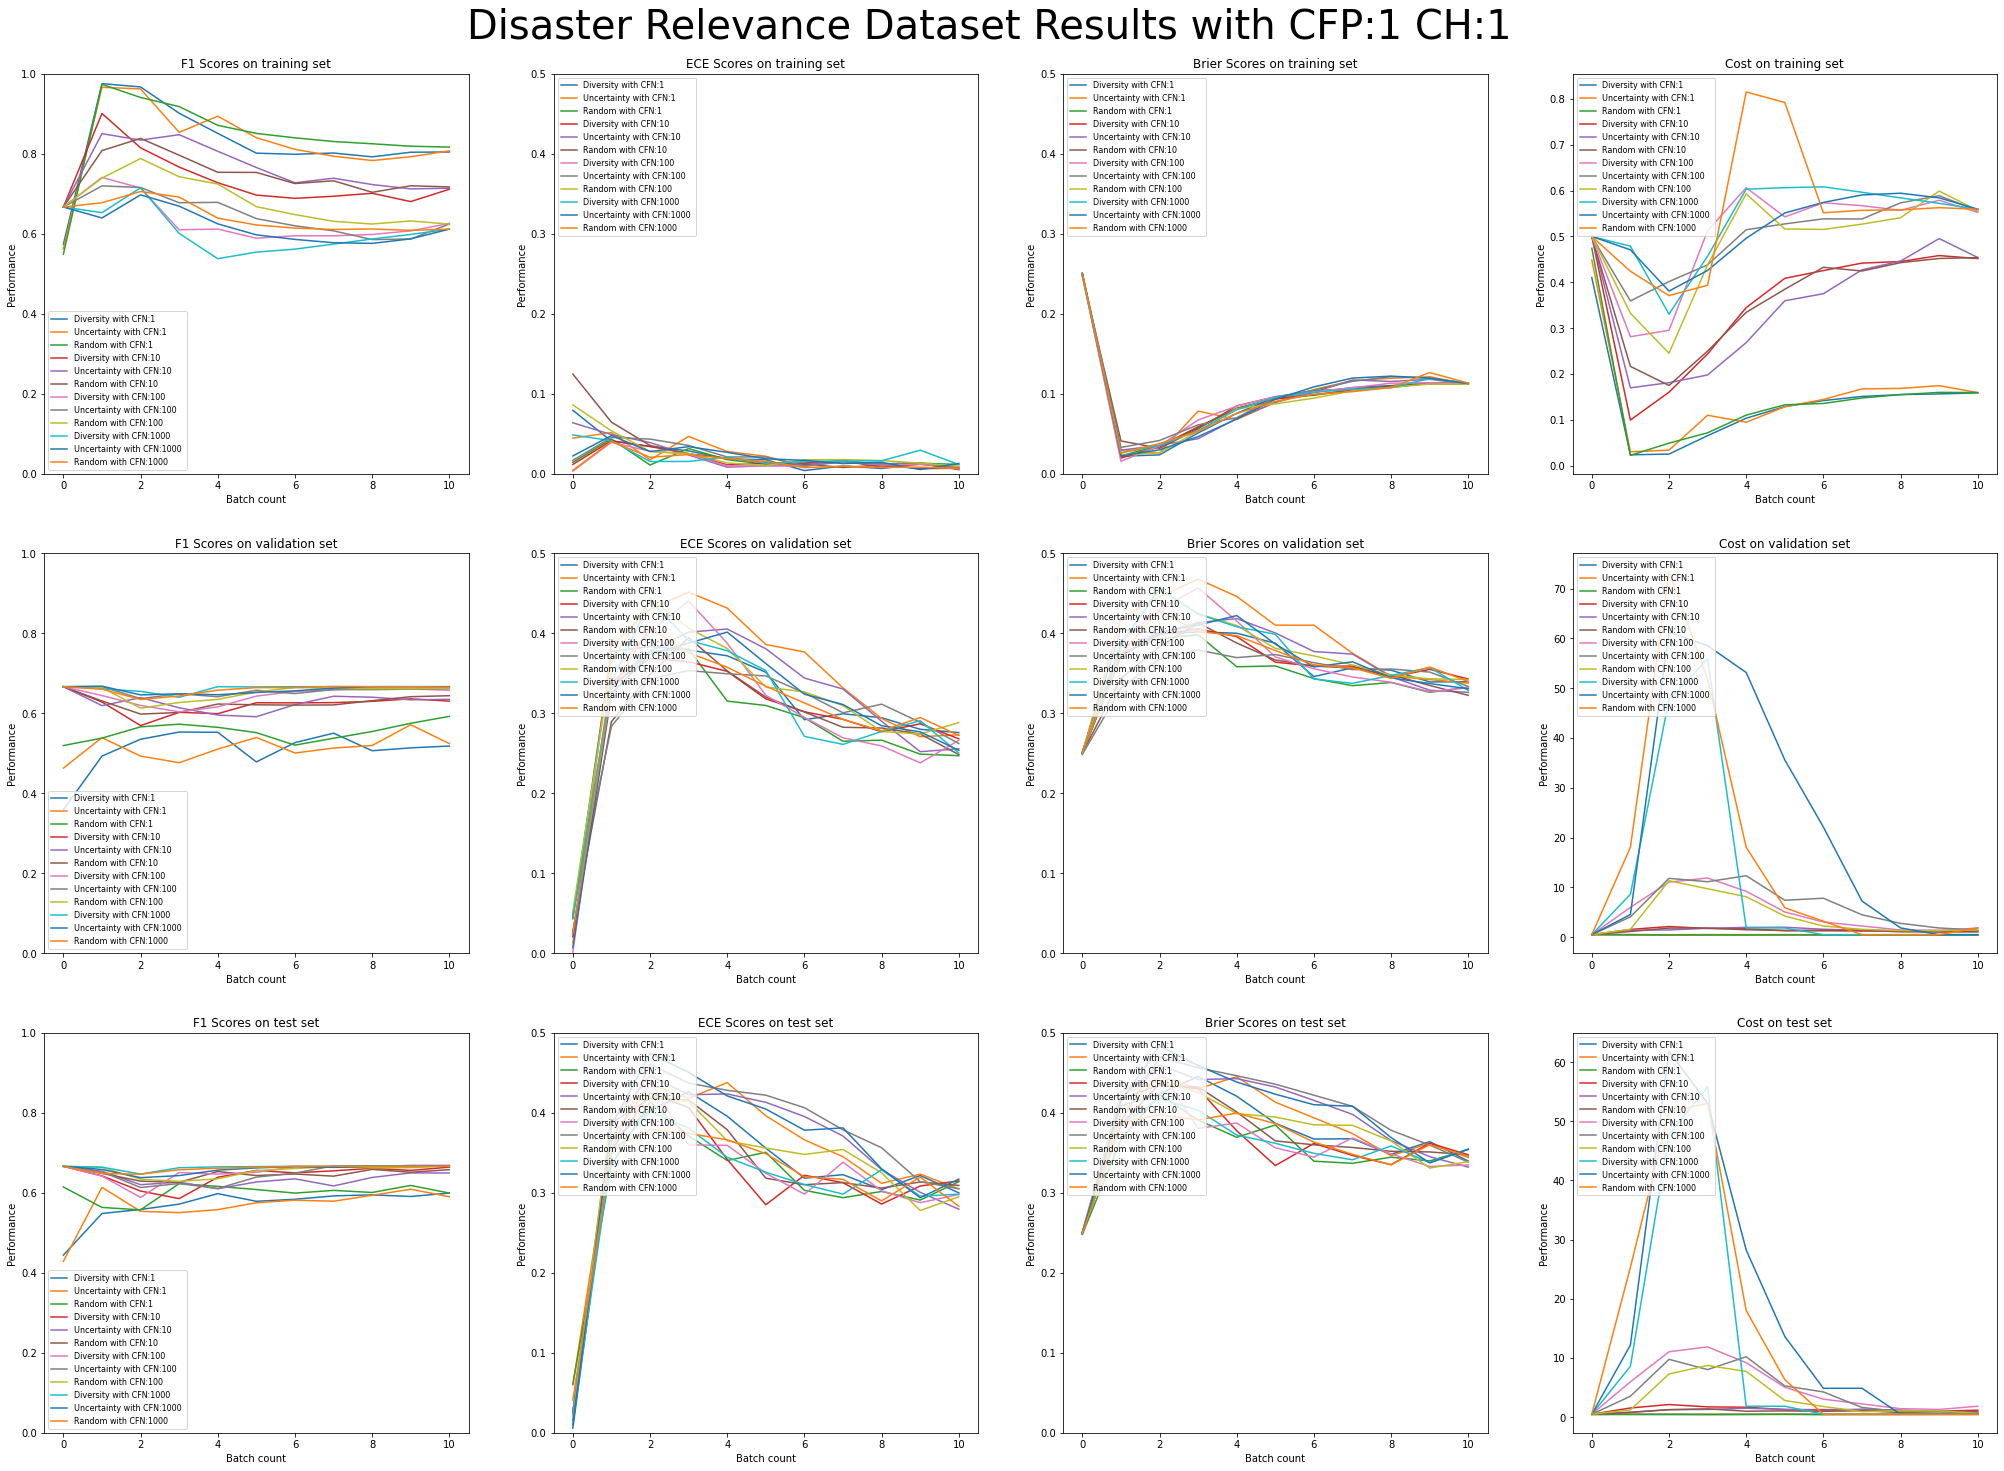

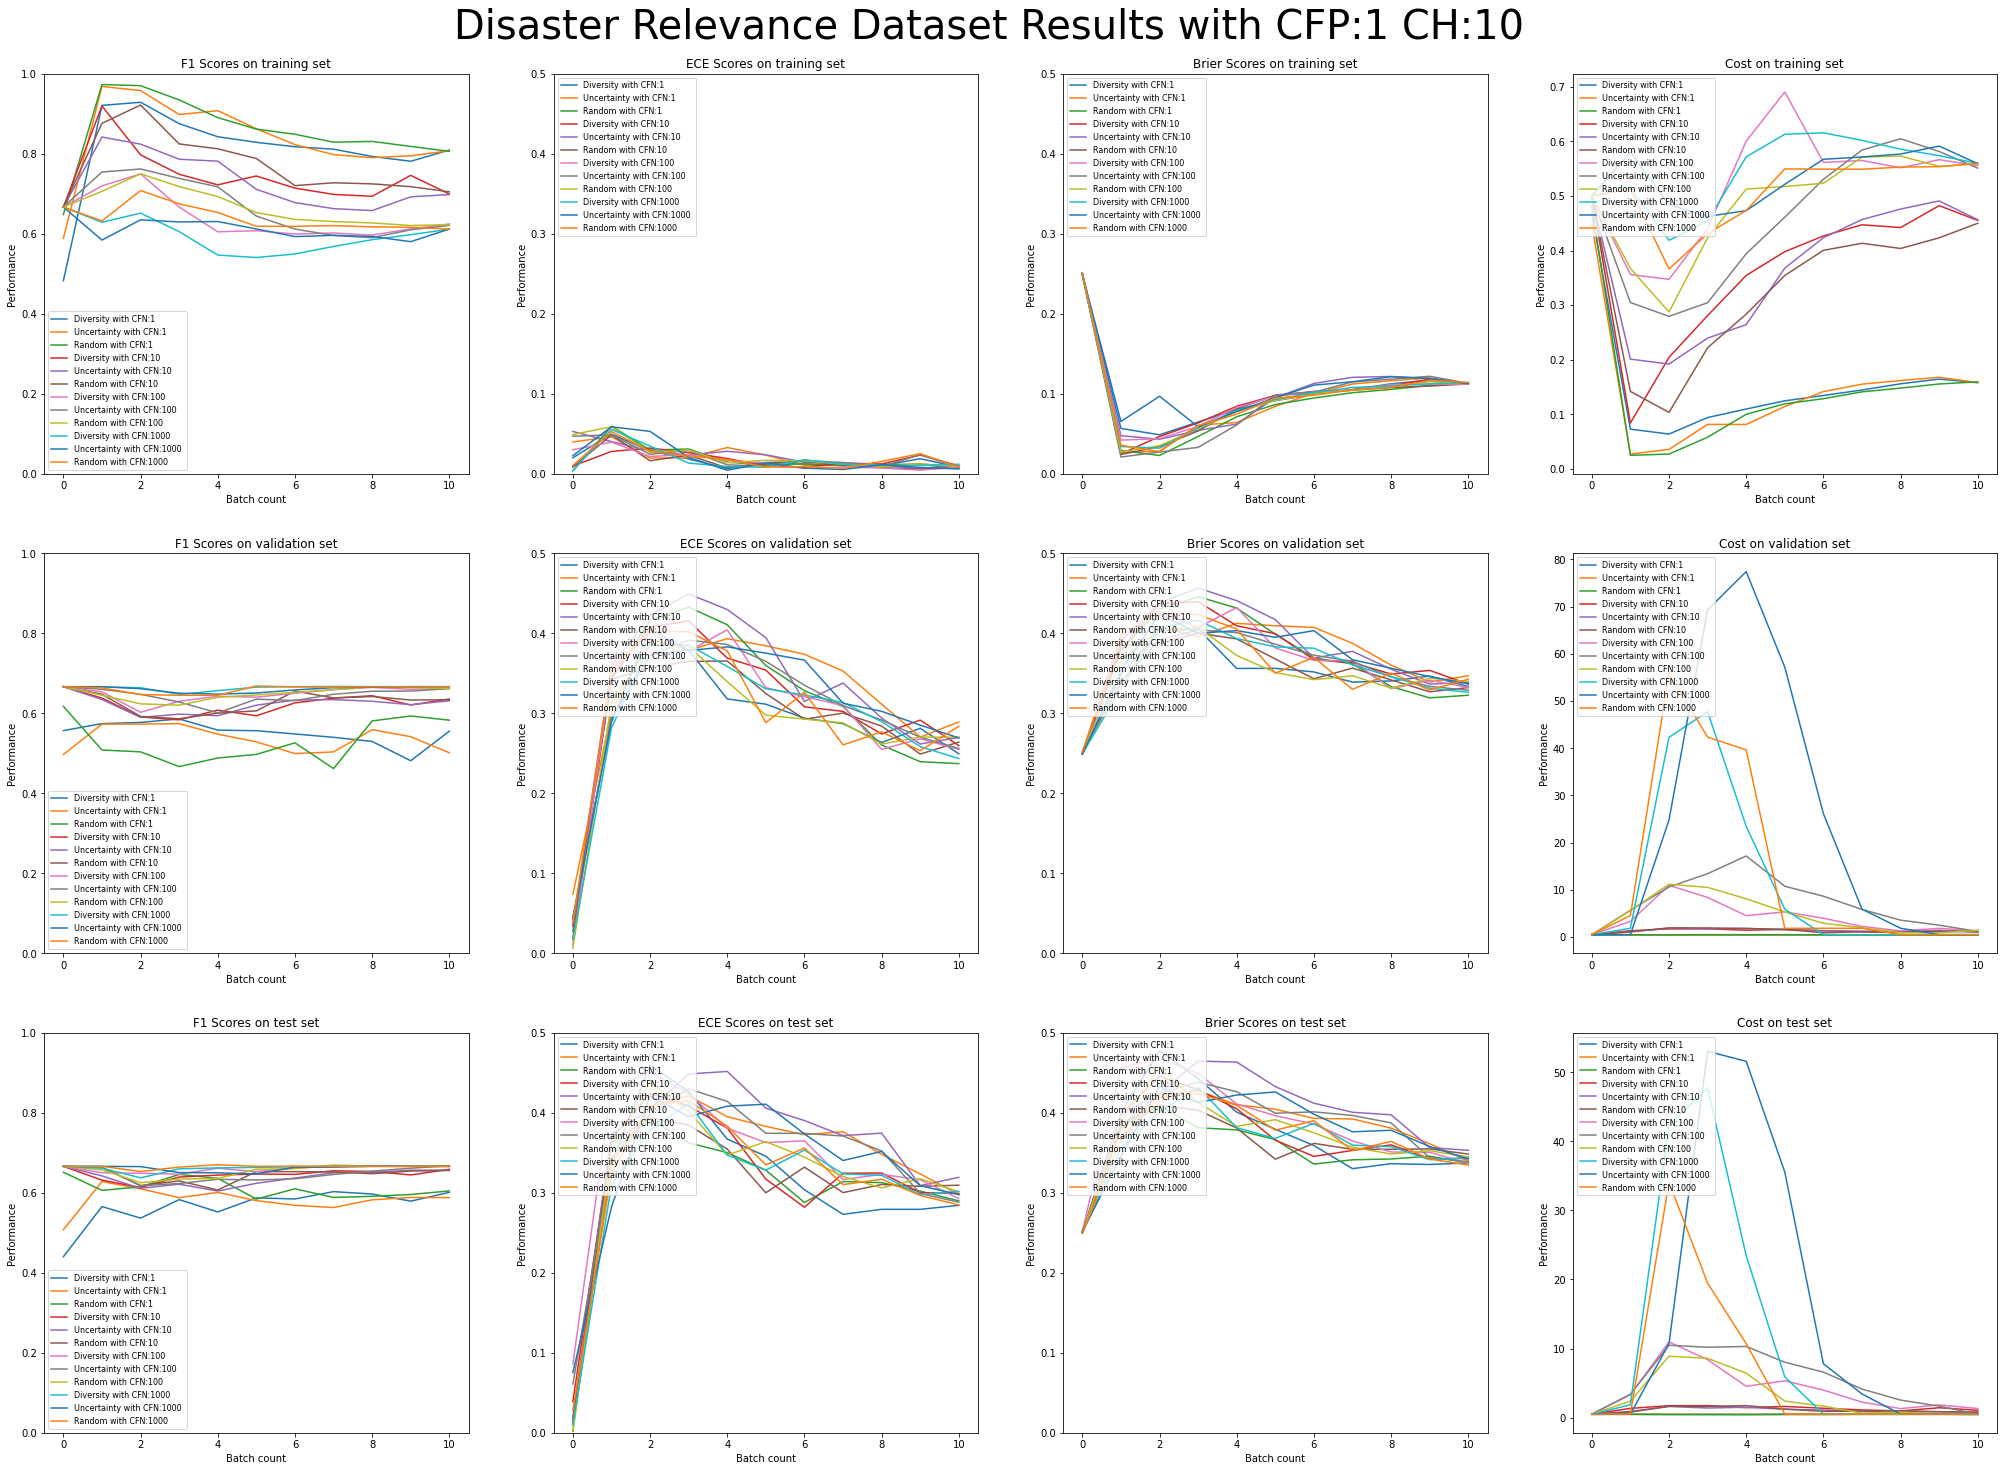

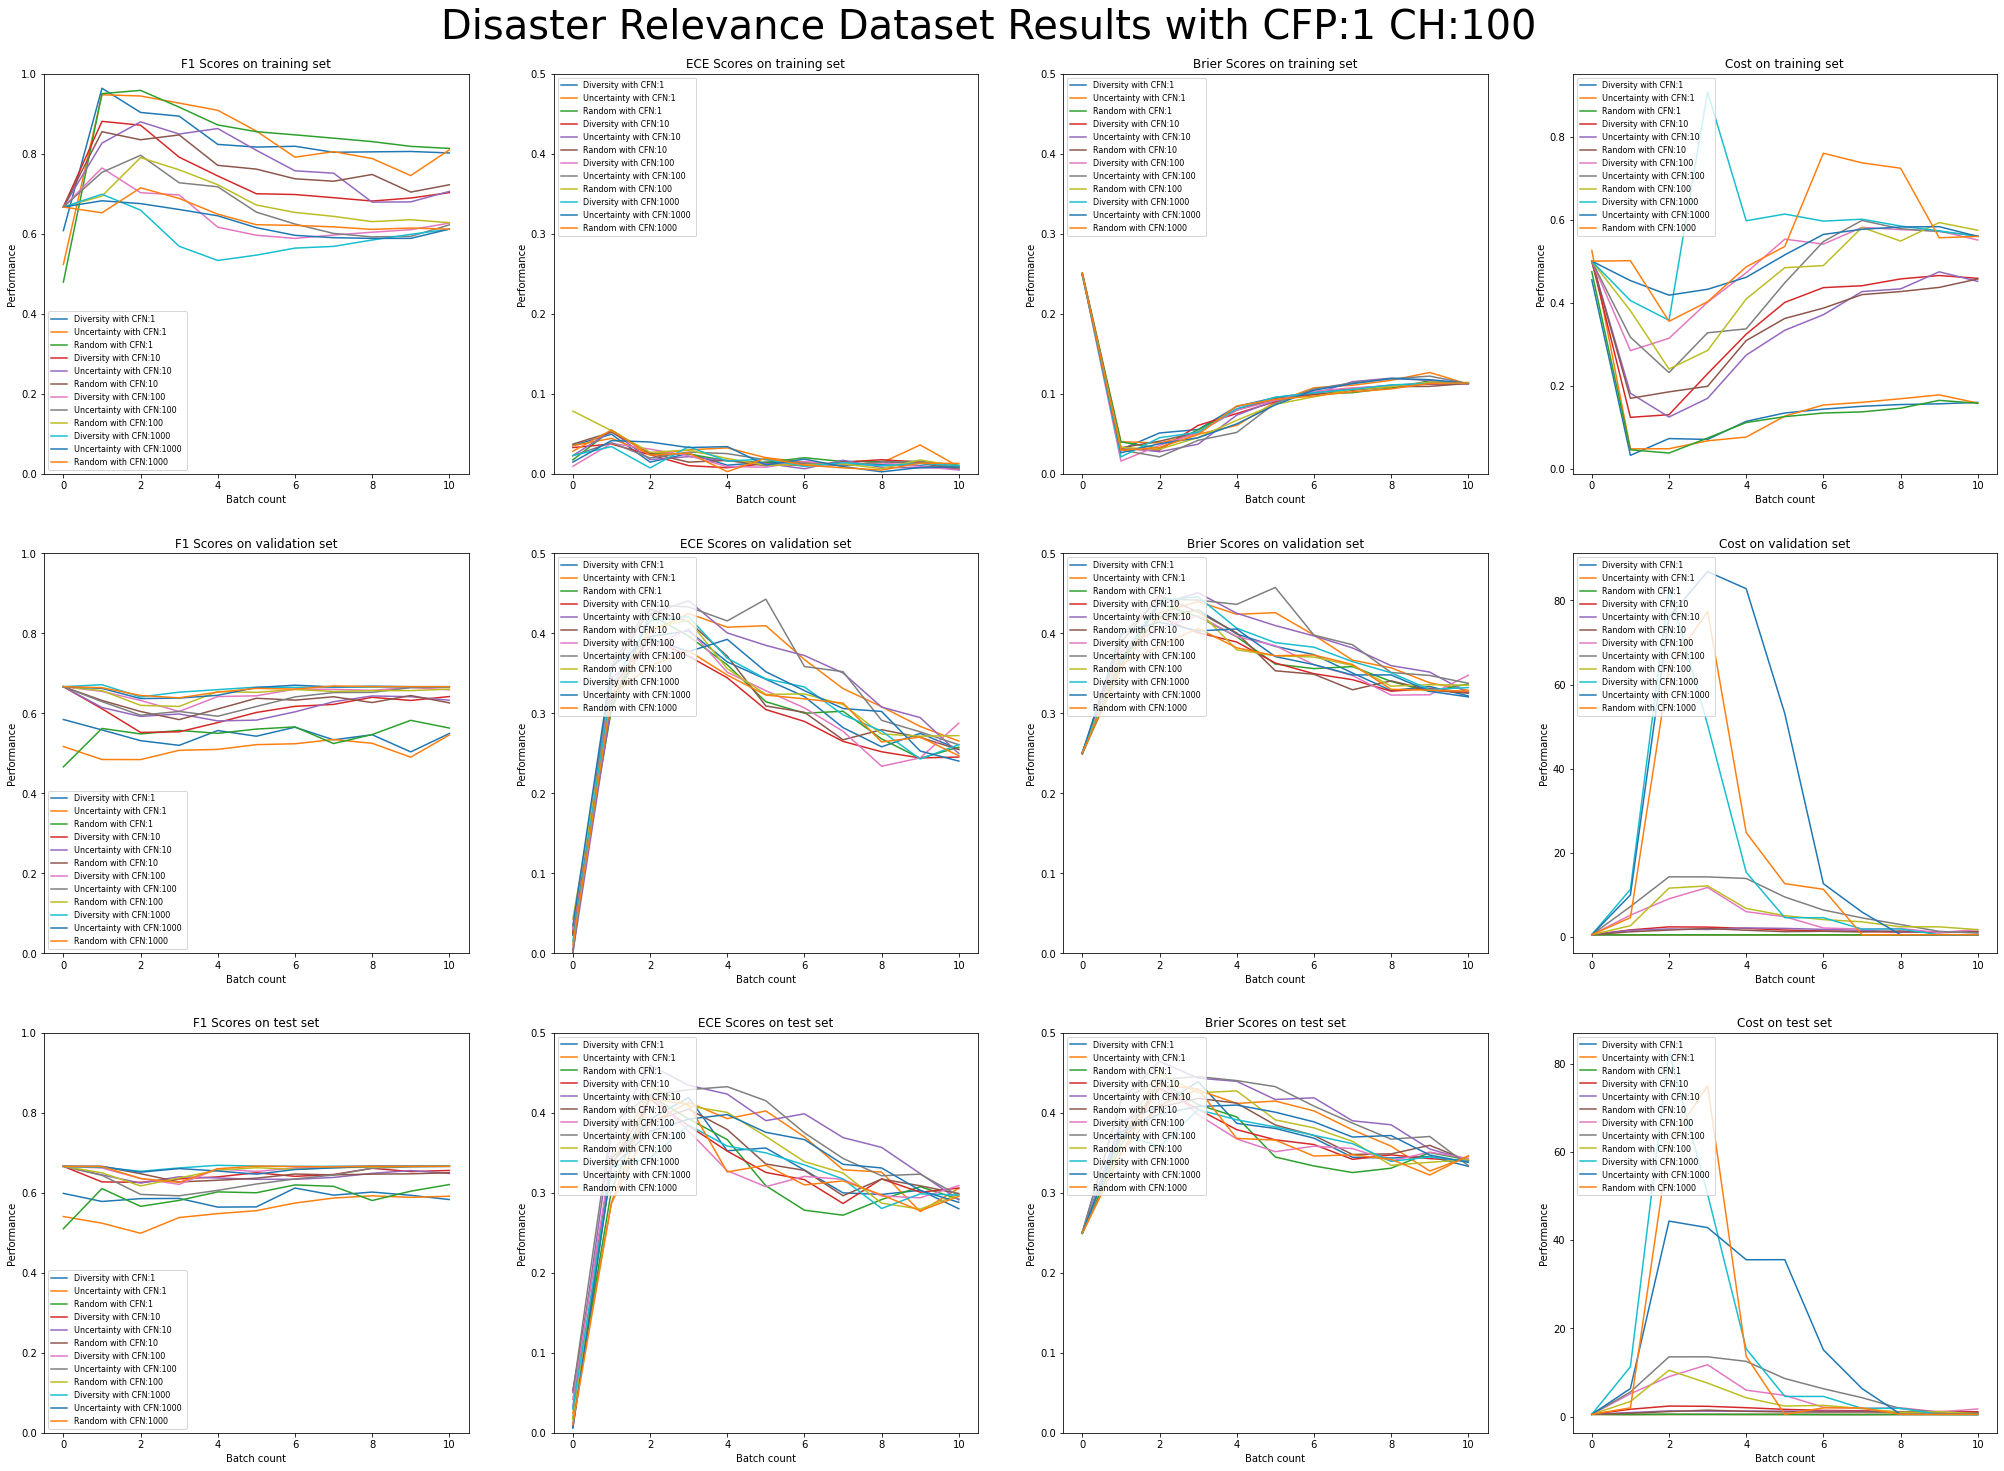

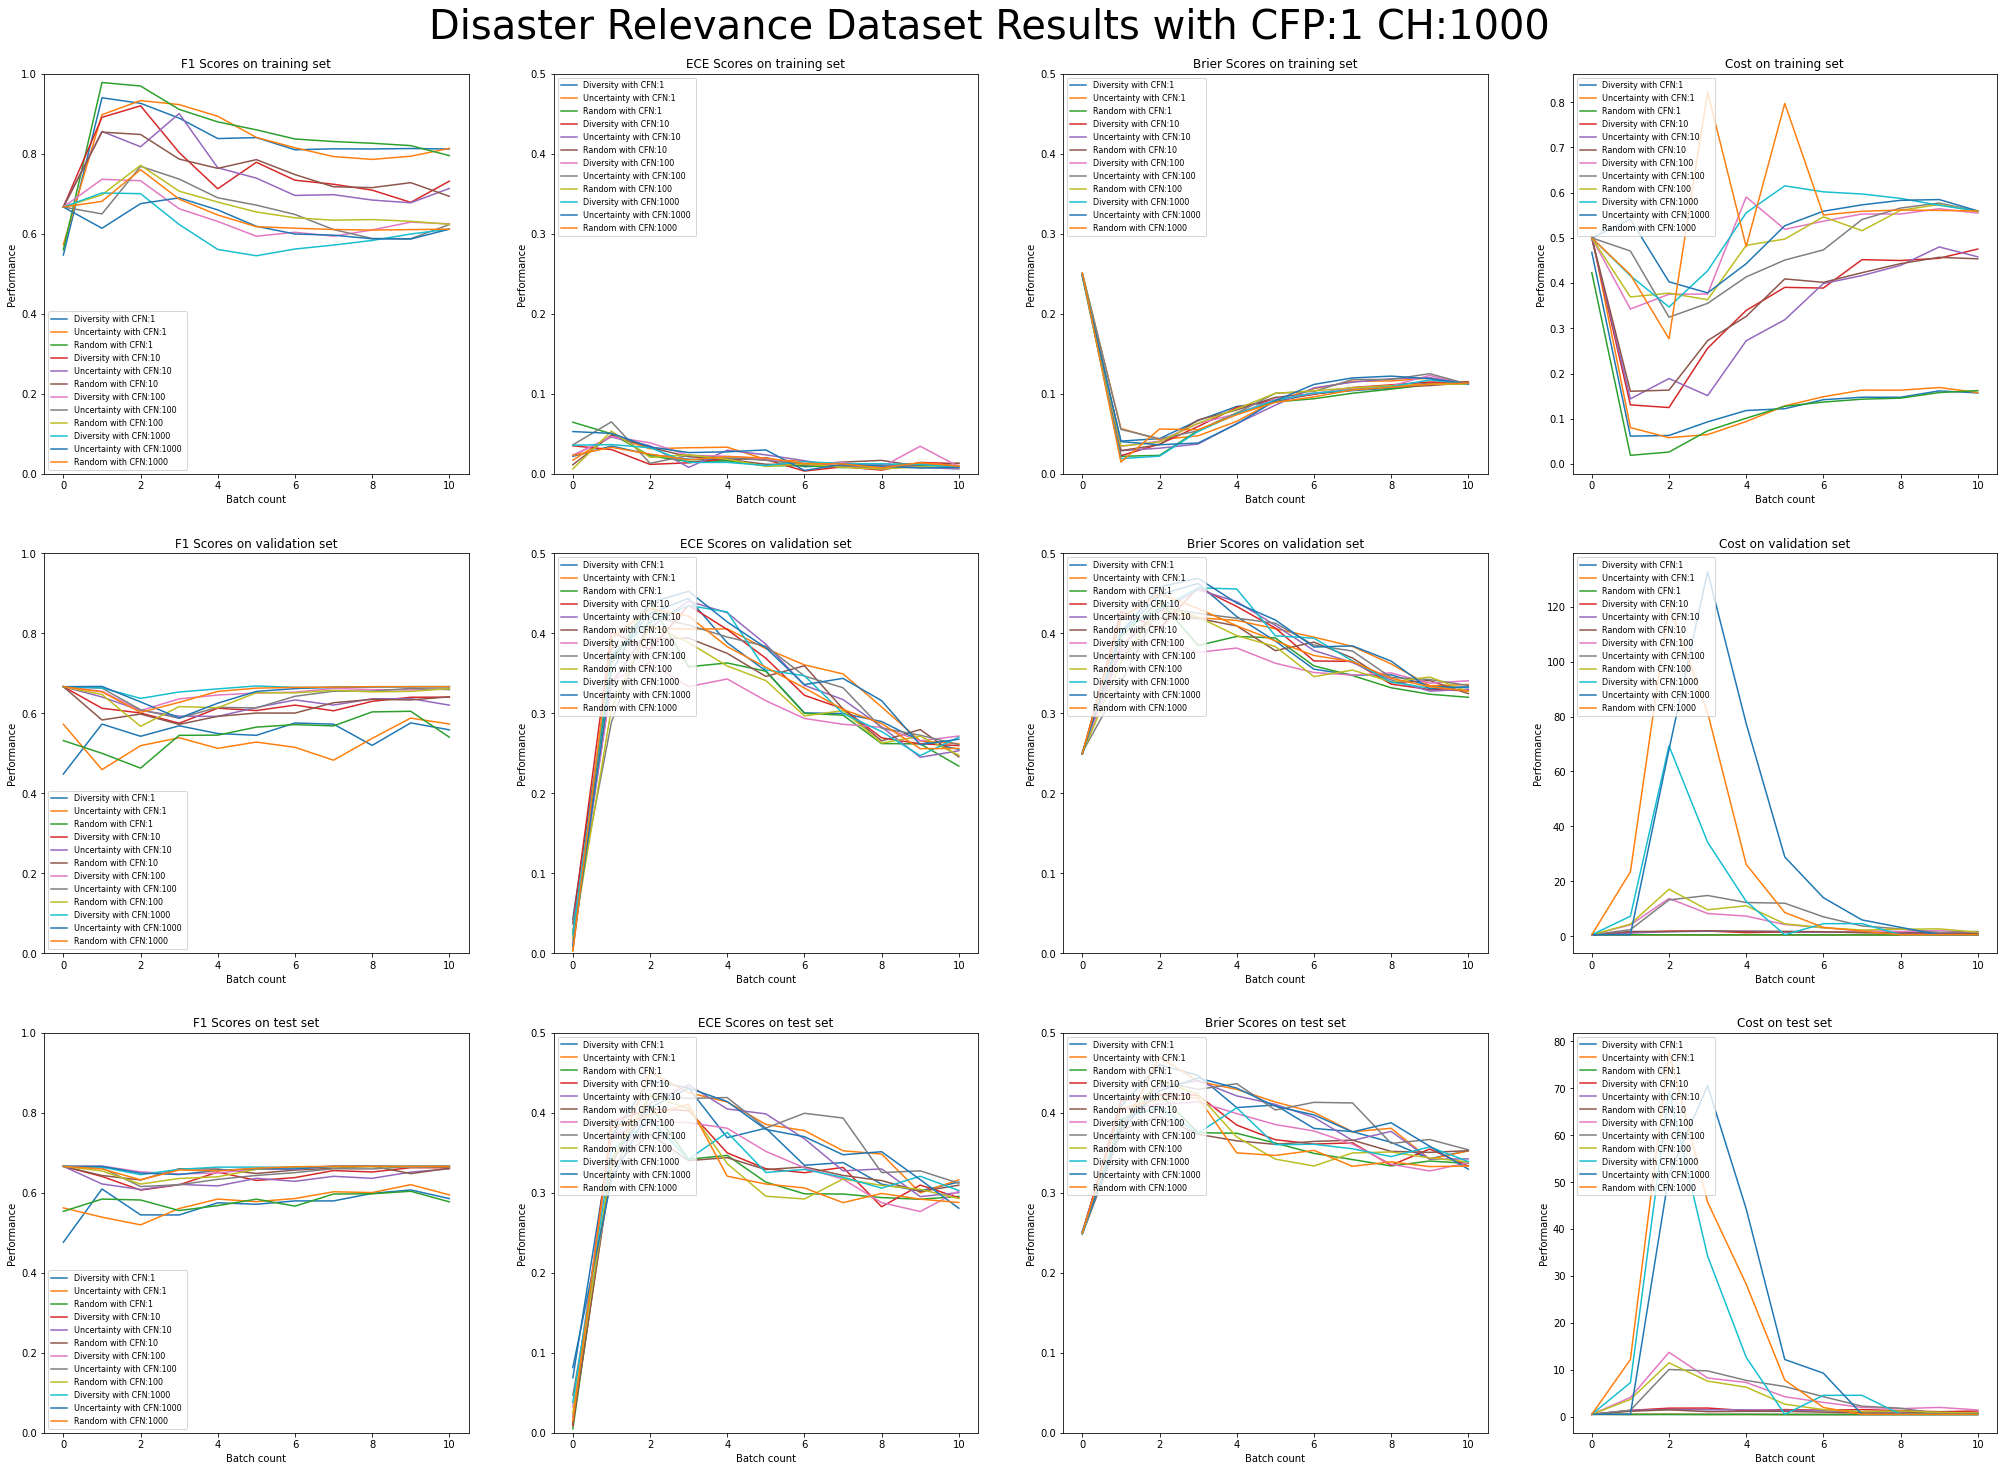

In [42]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/withCost/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/binary/disaster_relevance/'
                                        
cfnList   = [1, 10, 100, 1000]                           
chList    = [1, 10, 100, 1000]                           

for ch in chList:
    dataToPlot = []
    legendsToPlot = []
    for cfn in cfnList:
        dataF = data_folder + '2_train_indexed_disaster_relevance_binary.csv'
        r_resF = res_path + 'random_2-disasterRelevance-MLP3_cfp_1_cfn_{}_ch_{}.csv'.format(cfn, ch)
        u_resF = res_path + 'uncertainty_2-disasterRelevance-MLP3_cfp_1_cfn_{}_ch_{}.csv'.format(cfn, ch)
        d_resF = res_path + 'diversity_2-disasterRelevance-MLP3_cfp_1_cfn_{}_ch_{}.csv'.format(cfn, ch)

        data = pd.read_csv(dataF)
        r_res = pd.read_csv(r_resF)
        u_res = pd.read_csv(u_resF)
        d_res = pd.read_csv(d_resF)

        trainD = [d_res['alBatch'], [[d_res[" f1_train"].tolist(), d_res[" ece_train"].tolist(), d_res[" brier_train"].tolist(), d_res[" cost_train"].tolist()], [u_res[" f1_train"].tolist(), u_res[" ece_train"].tolist(), u_res[" brier_train"].tolist(), u_res[" cost_train"].tolist()], [r_res[" f1_train"].tolist(), r_res[" ece_train"].tolist(), r_res[" brier_train"].tolist(), r_res[" cost_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
        valD = [d_res['alBatch'], [[d_res[" f1_val"].tolist(), d_res[" ece_val"].tolist(), d_res[" brier_val"].tolist(), d_res[" cost_val"].tolist()], [u_res[" f1_val"].tolist(), u_res[" ece_val"].tolist(), u_res[" brier_val"].tolist(), u_res[" cost_val"].tolist()], [r_res[" f1_val"].tolist(), r_res[" ece_val"].tolist(), r_res[" brier_val"].tolist(), r_res[" cost_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
        testD = [d_res['alBatch'], [[d_res[" f1_test"].tolist(), d_res[" ece_test"].tolist(), d_res[" brier_test"].tolist(), d_res[" cost_val"].tolist()], [u_res[" f1_test"].tolist(), u_res[" ece_test"].tolist(), u_res[" brier_test"].tolist(), u_res[" cost_test"].tolist()], [r_res[" f1_test"].tolist(), r_res[" ece_test"].tolist(), r_res[" brier_test"].tolist(), r_res[" cost_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']
        dataToPlot.append([trainD, valD, testD])
        legendsToPlot.append('with CFN:{} '.format(cfn))
    plot_performance(dataToPlot, legendsToPlot, 'Disaster Relevance Dataset Results with CFP:1 CH:{}'.format(ch))